# <font color='violet'>Feature Engineering<font>

In the previous notebook, I ended up with a dataframe with all necessary rows and clean columns: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing1b_get_usable_df.ipynb

Here, I'll create a column that indicates how many times any given item has been ordered by a user in the past. Then use that to calculate the percentage of past orders where a user has purchased any given item. 

My intuition is that cross-row calculations don't count as leakage and negatively impact modeling IF I'm adding data that has exclusively to do with past orders. If this logic turns out to be inappropriate, I can just exclude these columns in modeling. 

Once that column has been completed, I'll engineer columns for product keywords and do any other feature engineering that seems meaningful prior to encoding and standardization that is better done as part of a modeling pipeline. 

In [1]:
import pandas as pd
import numpy as np
import os
from library.sb_utils import save_file

import random
import collections

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.lines as mlines

from IPython.display import Audio
sound_file = './alert.wav'

In [2]:
df = pd.read_csv('../data/processed/users_all_rows_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174119 entries, 0 to 2174118
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_by_user_sequence  int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   add_to_cart_sequence    int64  
 7   reordered               int64  
 8   product_name            object 
 9   aisle_name              object 
 10  dept_name               object 
dtypes: float64(1), int64(7), object(3)
memory usage: 182.5+ MB


**<font color='violet'>Group the dataframe and get a cumulative sum of purchases per product per user</font>**

In [3]:
# In order to get a cumsum of purchases, I'll need a 'purchased' column

df['purchased'] = 0
df['purchased'] = df[df['add_to_cart_sequence']>0]['purchased'].replace(0,1)
df['purchased'] = df['purchased'].fillna(0)

df['purchased'].value_counts()

0.0    1840246
1.0     333873
Name: purchased, dtype: int64

In [4]:
relevant_cols = df.loc[:,['user_id', 'order_by_user_sequence', 'purchased', 'product_name']]
grouped_df = relevant_cols.groupby(['user_id', 'product_name', 
                                    'order_by_user_sequence']).sum().groupby(
    level=[0,1]).cumsum().reset_index()
grouped_df[grouped_df['purchased']>1].head()

,user_id,product_name,order_by_user_sequence,purchased
45,75,All Natural Original Hummus,21,2.0
46,75,All Natural Original Hummus,22,2.0
47,75,All Natural Original Hummus,23,2.0
58,75,Asparation/Broccolini/Baby Broccoli,11,2.0
59,75,Asparation/Broccolini/Baby Broccoli,12,3.0


In [5]:
# Check out values of 'purchased' column for one user's purchases of one item.

grouped_df[grouped_df['product_name']=='All Natural Original Hummus']

,user_id,product_name,order_by_user_sequence,purchased
31,75,All Natural Original Hummus,7,1.0
32,75,All Natural Original Hummus,8,1.0
33,75,All Natural Original Hummus,9,1.0
34,75,All Natural Original Hummus,10,1.0
35,75,All Natural Original Hummus,11,1.0
36,75,All Natural Original Hummus,12,1.0
37,75,All Natural Original Hummus,13,1.0
38,75,All Natural Original Hummus,14,1.0
39,75,All Natural Original Hummus,15,1.0
40,75,All Natural Original Hummus,16,1.0


In [6]:
df = df.merge(grouped_df, on=['user_id', 'product_name', 'order_by_user_sequence'])
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
0,2108915,288,1,0,14,-1.0,1,0,Organic Avocado,fresh fruits,produce,1.0,1.0
1,2108915,288,1,0,14,-1.0,2,0,Organic Baby Arugula,packaged vegetables fruits,produce,1.0,1.0


In [7]:
df[(df['user_id']==75)&(df['product_name']=='All Natural Original Hummus')]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
1295527,2123286,75,7,0,14,6.0,10,0,All Natural Original Hummus,fresh dips tapenades,deli,1.0,1.0
1295727,3192011,75,21,0,13,22.0,7,1,All Natural Original Hummus,fresh dips tapenades,deli,1.0,2.0
1608947,690372,75,8,5,15,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1608985,64791,75,9,2,13,11.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609030,1047678,75,10,5,12,3.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609083,44604,75,11,4,11,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609152,20042,75,12,3,12,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609211,1354911,75,13,1,13,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609265,2391532,75,14,1,12,7.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609327,2641583,75,15,0,13,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0


In [8]:
# The merge succeeded. Work with purchased_y column to make sure it only shows past purchases.
df.loc[df['add_to_cart_sequence']>0, 'purchased_y'] -= 1
df[(df['user_id']==75)&(df['product_name']=='All Natural Original Hummus')]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
1295527,2123286,75,7,0,14,6.0,10,0,All Natural Original Hummus,fresh dips tapenades,deli,1.0,0.0
1295727,3192011,75,21,0,13,22.0,7,1,All Natural Original Hummus,fresh dips tapenades,deli,1.0,1.0
1608947,690372,75,8,5,15,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1608985,64791,75,9,2,13,11.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609030,1047678,75,10,5,12,3.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609083,44604,75,11,4,11,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609152,20042,75,12,3,12,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609211,1354911,75,13,1,13,5.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609265,2391532,75,14,1,12,7.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0
1609327,2641583,75,15,0,13,6.0,0,0,All Natural Original Hummus,fresh dips tapenades,deli,0.0,1.0


In [9]:
# The purchases_y column now contains the values I want. Clean this up.
df = df.drop(columns='purchased_x')
df = df.rename(columns={'purchased_y':'prior_purchases'})
df['prior_purchases'] = df['prior_purchases'].astype('int')
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,prior_purchases
0,2108915,288,1,0,14,-1.0,1,0,Organic Avocado,fresh fruits,produce,0
1,2108915,288,1,0,14,-1.0,2,0,Organic Baby Arugula,packaged vegetables fruits,produce,0


**<font color='violet'>Beyond a count of how many times a user has purchased an item in the past: In what portion of past orders has a user purchased an item?</font>**

In [10]:
# Create the column
df['purchased_percent_prior'] = df['prior_purchases'] / df['order_by_user_sequence']
df['purchased_percent_prior'].value_counts()

0.000000    137210
0.200000     55854
0.250000     55582
0.166667     54313
0.142857     52371
             ...  
0.393258         1
0.460674         1
0.847458         1
0.465909         1
0.402778         1
Name: purchased_percent_prior, Length: 2422, dtype: int64

In [11]:
df.sample(15)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,prior_purchases,purchased_percent_prior
856127,2528643,94529,49,4,17,6.0,4,1,Organic Banana,fresh fruits,produce,4,0.081633
446725,3156356,175332,6,5,7,8.0,4,0,Natural Chicken & Apple Breakfast Sausage Patty,frozen breakfast,frozen,0,0.000000
1398637,1502805,132363,66,4,13,7.0,0,0,Gummy Bears,candy chocolate,snacks,1,0.015152
1840348,1455900,65127,13,0,13,24.0,0,0,Traditional Panettone,other,other,1,0.076923
1740211,3124593,130341,19,3,19,30.0,2,1,Organic Baby Arugula,packaged vegetables fruits,produce,8,0.421053
17770,1653494,47399,14,6,17,28.0,14,0,Minced Garlic,canned jarred vegetables,canned goods,0,0.000000
1309570,2093851,49352,14,6,11,9.0,17,1,Total 2% Lowfat Greek Strained Yogurt with Peach,yogurt,dairy eggs,9,0.642857
1399432,2172570,132363,70,4,12,8.0,0,0,Dark Sweet Cherries,frozen produce,frozen,2,0.028571
2064934,2189164,113488,6,1,10,8.0,0,0,Lavender & Chamomile Scented Oil Refill,air fresheners candles,household,1,0.166667
1713605,97619,43027,11,2,19,6.0,10,0,Organic Broccoli,fresh vegetables,produce,0,0.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174119 entries, 0 to 2174118
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   order_id                 int64  
 1   user_id                  int64  
 2   order_by_user_sequence   int64  
 3   order_dow                int64  
 4   order_hour_of_day        int64  
 5   days_since_prior_order   float64
 6   add_to_cart_sequence     int64  
 7   reordered                int64  
 8   product_name             object 
 9   aisle_name               object 
 10  dept_name                object 
 11  prior_purchases          int64  
 12  purchased_percent_prior  float64
dtypes: float64(2), int64(8), object(3)
memory usage: 232.2+ MB


In [13]:
df.describe()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,prior_purchases,purchased_percent_prior
count,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06,2.174119e+06
mean,1.714335e+06,1.007551e+05,2.857891e+01,2.767469e+00,1.340722e+01,8.855513e+00,1.278327e+00,9.045641e-02,2.444300e+00,1.233999e-01
std,9.889512e+05,5.953240e+04,2.179073e+01,2.059496e+00,4.269585e+00,8.047374e+00,4.132511e+00,2.868346e-01,3.637663e+00,1.452078e-01
min,2.140000e+02,7.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.585620e+05,4.918700e+04,1.100000e+01,1.000000e+00,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.030303e-02
50%,1.721186e+06,9.830700e+04,2.300000e+01,3.000000e+00,1.300000e+01,6.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.896552e-02
75%,2.562645e+06,1.530290e+05,4.100000e+01,5.000000e+00,1.600000e+01,1.100000e+01,0.000000e+00,0.000000e+00,2.000000e+00,1.600000e-01
max,3.420932e+06,2.058220e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,8.200000e+01,1.000000e+00,7.900000e+01,9.782609e-01


This dataset now has all the necessary rows and columns in order to use it for making predictions. Every order by ever user contains a row for every item they have ever purchased, and the prior_purchases column contains the number of times a user has bought any given item *in the past*. This could be ready for encoding and modeling. 

First, though, I'll do some feature engineering with the product names to pull out potential keywords that could improve model performance. 

**<font color='violet'>Engineer columns for product keywords.</font>**

In [14]:
# Start with getting words that appear in product names but aren't already covered 
# by aisle and department classifications. 

all_prod_words = set(df['product_name'].tolist())
all_prod_words = [i.split() for i in all_prod_words]
all_prod_words = [i for sublist in all_prod_words for i in sublist]

aisle_words = set(df['aisle_name'].tolist())
aisle_words = [i.split() for i in aisle_words]
aisle_words = [i for sublist in aisle_words for i in sublist]
aisle_words = list(set(aisle_words))

dept_words = set(df['dept_name'].tolist())
dept_words = [i.split() for i in dept_words]
dept_words = [i for sublist in dept_words for i in sublist]
dept_words = list(set(dept_words))

all_prod_unique_words = [word for word in all_prod_words if word not in aisle_words]
all_prod_unique_words = [word for word in all_prod_words if word not in dept_words]

counts = collections.Counter(all_prod_words)
counts.most_common(60)

[('Organic', 2851),
 ('&', 1996),
 ('Chocolate', 1096),
 ('Cheese', 979),
 ('Free', 884),
 ('Original', 709),
 ('Chicken', 655),
 ('Yogurt', 597),
 ('Cream', 591),
 ('Whole', 591),
 ('Milk', 573),
 ('with', 532),
 ('Sauce', 516),
 ('Rice', 502),
 ('Butter', 490),
 ('Natural', 489),
 ('Vanilla', 481),
 ('White', 459),
 ('Mix', 430),
 ('Tea', 424),
 ('Bar', 415),
 ('Fruit', 407),
 ('Gluten', 401),
 ('Juice', 397),
 ('Chips', 371),
 ('Sweet', 370),
 ('Dark', 369),
 ('Coconut', 364),
 ('Cheddar', 349),
 ('Oil', 334),
 ('Bread', 328),
 ('and', 326),
 ('100%', 325),
 ('Ice', 325),
 ('Almond', 318),
 ('Green', 317),
 ('Salt', 316),
 ('Fat', 315),
 ('Strawberry', 314),
 ('Apple', 306),
 ('Baby', 306),
 ('Water', 306),
 ('Fresh', 304),
 ('Coffee', 303),
 ('Grain', 296),
 ('With', 295),
 ('Food', 291),
 ('Style', 287),
 ('Roasted', 286),
 ('Lemon', 285),
 ('Red', 279),
 ('Pasta', 278),
 ('Black', 278),
 ('Honey', 277),
 ('Peanut', 271),
 ('Soup', 269),
 ('Potato', 257),
 ('Classic', 257),
 ('Bar

Now, if high-frequency words appear in products across many different departments, it could  sense to give them their own column. Explore words with counts over 300. "Fresh" seems like a meaningful feature, but none of the words that appear under 300 times seem to be as meaningul as product types. Do remove obviously useless words like '&'.

In [15]:
potential_keywords = ['Organic','Chocolate','Cheese','Free','Original','Chicken','Yogurt',
                      'Cream','Whole','Milk','Sauce','Rice','Butter','Natural','Vanilla',
                      'White','Mix','Tea','Bar','Fruit','Gluten','Juice','Chips','Sweet','Dark',
                      'Coconut','Cheddar','Oil','Bread','Ice','Almond','Green','Salt','Fat',
                      'Strawberry','Apple','Water','Baby','Fresh','Coffee']

potential_keywords.sort()

for k in potential_keywords:
    print(k, ': ', len(df[df['product_name'].str.contains(k)]['dept_name'].unique()))

Almond :  13
Apple :  18
Baby :  15
Bar :  19
Bread :  11
Butter :  16
Cheddar :  14
Cheese :  17
Chicken :  13
Chips :  8
Chocolate :  13
Coconut :  17
Coffee :  10
Cream :  19
Dark :  15
Fat :  13
Free :  19
Fresh :  18
Fruit :  17
Gluten :  14
Green :  19
Ice :  13
Juice :  13
Milk :  12
Mix :  18
Natural :  19
Oil :  14
Organic :  20
Original :  20
Rice :  16
Salt :  14
Sauce :  14
Strawberry :  13
Sweet :  19
Tea :  13
Vanilla :  15
Water :  13
White :  20
Whole :  17
Yogurt :  11


To me, it would make sense to put the cutoff at words that appear across more than 17 departments: Apple, Bar, Cream, Free, Fresh, Green, Mix, Natural, Organic, Original, Sweet, White. Keywords that appear across 16-17 departments are butter, cheese, coconut, fruit, rice, and whole. None of these except maybe "whole" seem as meaningful as organic, fresh, or white. 

In [16]:
# Start a column for each keyword.

keywords = ['apple', 'bar', 'cream', 'free', 'fresh', 'green', 'mix', 'natural', 'organic', 
            'original', 'sweet', 'white']

df[keywords] = 0
df.columns

Index(['order_id', 'user_id', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_sequence',
       'reordered', 'product_name', 'aisle_name', 'dept_name',
       'prior_purchases', 'purchased_percent_prior', 'apple', 'bar', 'cream',
       'free', 'fresh', 'green', 'mix', 'natural', 'organic', 'original',
       'sweet', 'white'],
      dtype='object')

In [17]:
# Fill each column with a 1 where the word appears in the product name.

for k in keywords:
    df[k] = df[k].mask(df['product_name'].str.contains(k.title()), 1)

df['organic'].value_counts()

0    1479745
1     694374
Name: organic, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174119 entries, 0 to 2174118
Data columns (total 25 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   order_id                 int64  
 1   user_id                  int64  
 2   order_by_user_sequence   int64  
 3   order_dow                int64  
 4   order_hour_of_day        int64  
 5   days_since_prior_order   float64
 6   add_to_cart_sequence     int64  
 7   reordered                int64  
 8   product_name             object 
 9   aisle_name               object 
 10  dept_name                object 
 11  prior_purchases          int64  
 12  purchased_percent_prior  float64
 13  apple                    int64  
 14  bar                      int64  
 15  cream                    int64  
 16  free                     int64  
 17  fresh                    int64  
 18  green                    int64  
 19  mix                      int64  
 20  natural                  int64  
 21  organic 

**<font color='violet'>Deal with 'missing' department</font>**

Product keyword columns got created successfully. Now, Look into departments to see which products belong to 'missing' and 'other' columns. Consider if reclassification makes sense.

In [19]:
print(len(df[df['dept_name']=='missing']['product_name'].unique()))
print(len(df[df['dept_name']=='other']['product_name'].unique()))

231
138


Most products seem like they could actually be reclassified easily into another existing category. With over 350 products, though, it would impractical to re-categorize them all myself. Plus, while I can easily guess some products' aisles and departments, if I don't know whether peanuts, for example, are in tiny bags or bulk, I could just muddy other departments and whatever intrinsic 'reorder-ability' they come with. 

Therefore, I will keep this data as-is, at least for now. I can try when doing initial modeling to see if models perform  better when actually removing rows where department=missing. It is common practice to remove nan rows, and 'missing' is fundamentally the same as nan. This would lead to an inability to predict whether items from that department are reordered, but it could improve predictive abilities of the model as a whole by leaving the model with a more coherent "department" category as a feature. 

**<font color='violet'>Another New Column: How often in the past has an item been one of the first 6 to be added to a cart?</font>**

During early EDA, I found that many products that are reorders get placed in a cart early on, up to item 6. It does not necessarily follow that items that have been placed in carts early on in the past will be more likely to be reordered in any given order, but it could be worth creating a column to indicate "percent of past orders where this item has been one of the firs 6 items placed in a cart."

In [20]:
# First, just create a column showing whether an item was purchased early
df['purchased_early']=0
df.loc[((df['add_to_cart_sequence']<=6) & (df['add_to_cart_sequence']>0)), 'purchased_early'] = 1
df[df['add_to_cart_sequence']==0].head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,free,fresh,green,mix,natural,organic,original,sweet,white,purchased_early
62186,1230054,203749,2,0,17,30.0,0,0,Gala Apples,fresh fruits,...,0,0,0,0,0,0,0,0,0,0
62187,1230054,203749,2,0,17,30.0,0,0,Large Grapefruit,fresh fruits,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Check to make sure this columns is correct so far.
df[df['add_to_cart_sequence']==6].head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,free,fresh,green,mix,natural,organic,original,sweet,white,purchased_early
6,1158794,288,2,1,11,30.0,6,0,Organic Zucchini,fresh vegetables,...,0,0,0,0,0,1,0,0,0,1
13,1179462,288,3,0,21,30.0,6,0,Shredded Mozzarella,packaged cheese,...,0,0,0,0,0,0,0,0,0,1


In [22]:
df[df['add_to_cart_sequence']==7].head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,free,fresh,green,mix,natural,organic,original,sweet,white,purchased_early
8,1158794,288,2,1,11,30.0,7,0,YoKids Squeeze! Organic Strawberry Flavor Yogurt,yogurt,...,0,0,0,0,0,1,0,0,0,0
10,1179462,288,3,0,21,30.0,7,1,Organic Whole Milk,milk,...,0,0,0,0,0,1,0,0,0,0


In [23]:
# Group and get the cumulative sum of how many times an item has been purchased early
relevant_cols = df.loc[:,['user_id', 'order_by_user_sequence', 'purchased_early', 'product_name']]
grouped_df = relevant_cols.groupby(['user_id', 'product_name', 
                                    'order_by_user_sequence']).sum().groupby(
    level=[0,1]).cumsum().reset_index()
grouped_df[grouped_df['purchased_early']>0].head()

,user_id,product_name,order_by_user_sequence,purchased_early
58,75,Asparation/Broccolini/Baby Broccoli,11,1
59,75,Asparation/Broccolini/Baby Broccoli,12,2
60,75,Asparation/Broccolini/Baby Broccoli,13,2
61,75,Asparation/Broccolini/Baby Broccoli,14,2
62,75,Asparation/Broccolini/Baby Broccoli,15,2


In [24]:
# Check to make sure this turned out accurately
grouped_df[(grouped_df['user_id']==75)&
           (grouped_df['product_name']=='Asparation/Broccolini/Baby Broccoli')]

,user_id,product_name,order_by_user_sequence,purchased_early
52,75,Asparation/Broccolini/Baby Broccoli,5,0
53,75,Asparation/Broccolini/Baby Broccoli,6,0
54,75,Asparation/Broccolini/Baby Broccoli,7,0
55,75,Asparation/Broccolini/Baby Broccoli,8,0
56,75,Asparation/Broccolini/Baby Broccoli,9,0
57,75,Asparation/Broccolini/Baby Broccoli,10,0
58,75,Asparation/Broccolini/Baby Broccoli,11,1
59,75,Asparation/Broccolini/Baby Broccoli,12,2
60,75,Asparation/Broccolini/Baby Broccoli,13,2
61,75,Asparation/Broccolini/Baby Broccoli,14,2


In [25]:
df[(df['user_id']==75)&
           (df['product_name']=='Asparation/Broccolini/Baby Broccoli')].sort_values(
    'order_by_user_sequence').head(9)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,free,fresh,green,mix,natural,organic,original,sweet,white,purchased_early
1295496,2003456,75,5,1,14,4.0,15,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608893,207152,75,6,1,13,7.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608926,2123286,75,7,0,14,6.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608965,690372,75,8,5,15,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1609003,64791,75,9,2,13,11.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1609054,1047678,75,10,5,12,3.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1295567,44604,75,11,4,11,6.0,2,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,1
1295580,20042,75,12,3,12,6.0,4,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,1
1609198,1354911,75,13,1,13,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0


This user's 'purchased_early' value went up correctly in each order where add_to_cart_sequence <= 6

<font color='violet'>Merge cumsum purchased_early column with remaining df. Subtract 1 from each row where the 'early purchase' actually occured (to avoid leakage).</font>

In [26]:
df = df.merge(grouped_df, on=['user_id', 'product_name', 'order_by_user_sequence'])
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_x,purchased_early_y
0,2108915,288,1,0,14,-1.0,1,0,Organic Avocado,fresh fruits,...,0,0,0,0,1,0,0,0,1,1
1,2108915,288,1,0,14,-1.0,2,0,Organic Baby Arugula,packaged vegetables fruits,...,0,0,0,0,1,0,0,0,1,1


In [27]:
df[(df['user_id']==75)&
           (df['product_name']=='Asparation/Broccolini/Baby Broccoli')].sort_values(
    'order_by_user_sequence').head(10)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_x,purchased_early_y
1295496,2003456,75,5,1,14,4.0,15,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608893,207152,75,6,1,13,7.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608926,2123286,75,7,0,14,6.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608965,690372,75,8,5,15,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1609003,64791,75,9,2,13,11.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1609054,1047678,75,10,5,12,3.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1295567,44604,75,11,4,11,6.0,2,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,1,1
1295580,20042,75,12,3,12,6.0,4,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,1,2
1609198,1354911,75,13,1,13,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,2
1295605,2391532,75,14,1,12,7.0,13,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,2


In [28]:
# The merge worked. Fix rows where early purchases occurred. 
df.loc[((df['add_to_cart_sequence']>0) & (df['add_to_cart_sequence']<=6)), 
       'purchased_early_y'] -= 1

df[(df['user_id']==75)&
           (df['product_name']=='Asparation/Broccolini/Baby Broccoli')].sort_values(
    'order_by_user_sequence').head(9)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_x,purchased_early_y
1295496,2003456,75,5,1,14,4.0,15,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608893,207152,75,6,1,13,7.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608926,2123286,75,7,0,14,6.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1608965,690372,75,8,5,15,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1609003,64791,75,9,2,13,11.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1609054,1047678,75,10,5,12,3.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0
1295567,44604,75,11,4,11,6.0,2,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,1,0
1295580,20042,75,12,3,12,6.0,4,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,1,1
1609198,1354911,75,13,1,13,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,2


In [29]:
# Purchased_early_y contains the correct values. Clean this up.
df = df.drop(columns = 'purchased_early_x')
df = df.rename(columns = {'purchased_early_y':'purchased_early_past'})
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,free,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past
0,2108915,288,1,0,14,-1.0,1,0,Organic Avocado,fresh fruits,...,0,0,0,0,0,1,0,0,0,0
1,2108915,288,1,0,14,-1.0,2,0,Organic Baby Arugula,packaged vegetables fruits,...,0,0,0,0,0,1,0,0,0,0


In [30]:
# Check to make sure later orders also showing correct values in this column.
df['purchased_early_past'].max()

73

In [31]:
df[df['purchased_early_past']==73]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,free,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past
57054,592168,185457,100,2,19,1.0,4,1,"Diet Tangerine Lime Premium Soda, Zero Calorie...",soft drinks,...,1,0,0,0,0,0,0,0,0,73


<font color='violet'>Add column for percentage of past orders where an item was purchased early on.</font>

In [32]:
df['percent_past_purchased_early'] = df['purchased_early_past'] / df['order_by_user_sequence'] 

df[(df['user_id']==75)&
           (df['product_name']=='Asparation/Broccolini/Baby Broccoli')].sort_values(
    'order_by_user_sequence').head(10)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past,percent_past_purchased_early
1295496,2003456,75,5,1,14,4.0,15,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0.000000
1608893,207152,75,6,1,13,7.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0.000000
1608926,2123286,75,7,0,14,6.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0.000000
1608965,690372,75,8,5,15,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0.000000
1609003,64791,75,9,2,13,11.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0.000000
1609054,1047678,75,10,5,12,3.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0.000000
1295567,44604,75,11,4,11,6.0,2,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,0,0.000000
1295580,20042,75,12,3,12,6.0,4,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,1,0.083333
1609198,1354911,75,13,1,13,5.0,0,0,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,2,0.153846
1295605,2391532,75,14,1,12,7.0,13,1,Asparation/Broccolini/Baby Broccoli,fresh vegetables,...,0,0,0,0,0,0,0,0,2,0.142857


I now have correct columns indicating past purchases where an item was placed in the cart early. 

Do any of these new columns have a higher correlation to the target variable than columns did in the past?

**<font color='violet'>Visualize new columns</font>**

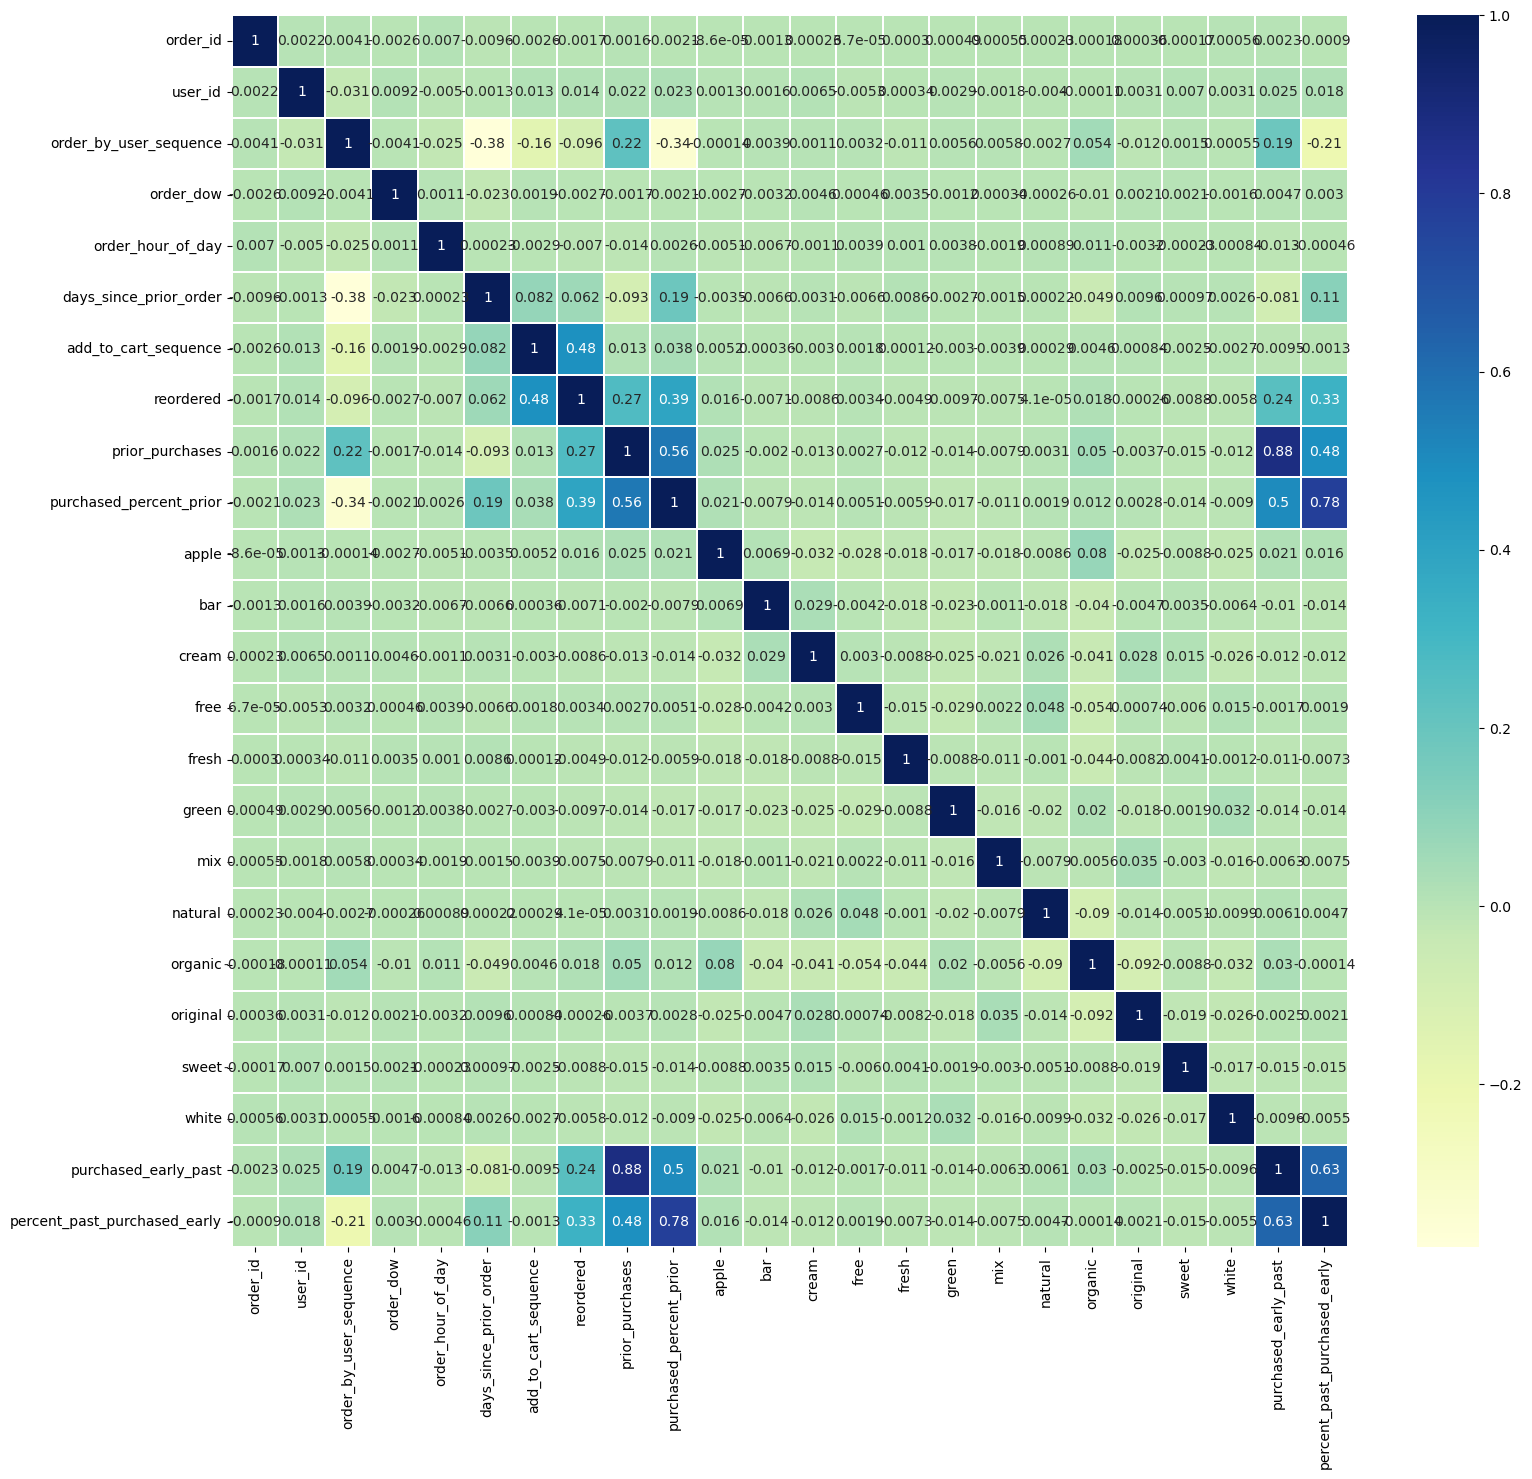

In [33]:
plt.figure(figsize=(18,16))
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

This isn't very readable. But it shows that most columns aren't particularly meaningful. Try this again with just those columns that have noticable correlations with one another. And change other plot features to make it more readable. For example, I don't care whether something has a positive or negative correlation. Use the absolute value so that the scale strictly indicates correlation strength. 

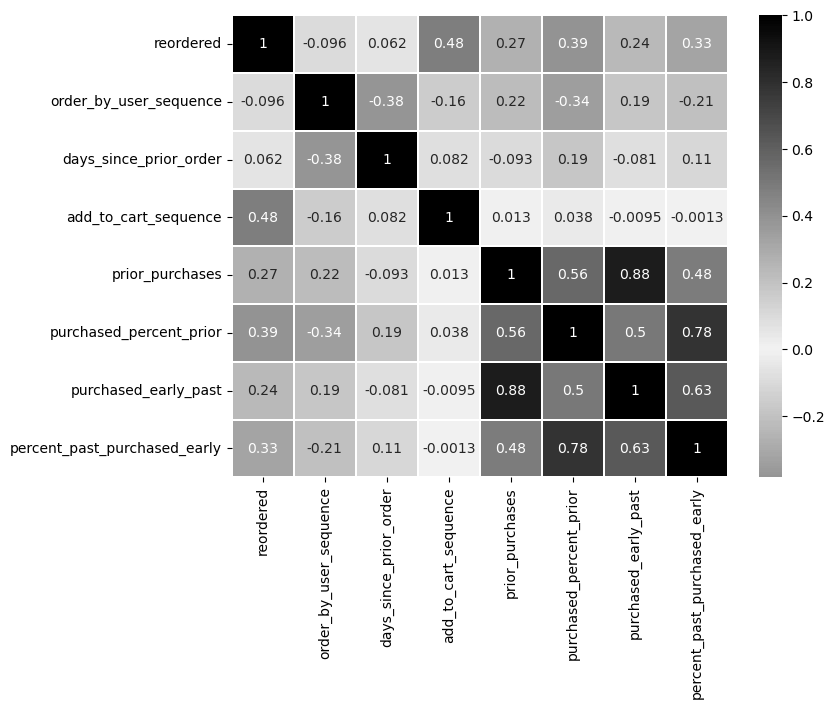

In [34]:
plt.figure(figsize=(8,6))
cmap = sns.diverging_palette(h_neg=0, h_pos=0, s=0, l=0, as_cmap=True)
sns.heatmap(df[['reordered', 'order_by_user_sequence', 'days_since_prior_order', 
               'add_to_cart_sequence', 'prior_purchases', 'purchased_percent_prior', 
               'purchased_early_past', 'percent_past_purchased_early']].corr(), 
            linewidths=.1, cmap=cmap, center=0.0, annot=True)
plt.yticks(rotation=0);

Predictably, the prior_puchases column has a higher correlation with 'reordered' than any previously-existing column. The purchased_percent_prior has an even higher correlation, almost as high as 'add_to_cart_sequence,' which is actually another dependent variable and closely predictive of reorders given that 100% of reorders occur where add_to_cart_sequence>0. So purchased_percent_prior, despite not leaking data about the current order's actual target variable, is a strong predictor and will be very useful in modeling. 

Likewise, the percent_past_purchased_early column, while not as strongly correlated with reorders as percent_purchased_prior, is, as I predicted, likely to be one of the most important features when it comes to making predictions.

After the columns indicating past orders and past early adds, the feature next most correlated with reorders is "days since prior order." Even this, though, is only a sixth as well-correlated with reorder status, so I'm very glad I added these new columns.

Do some further visualization with the new columns and "reordered." 

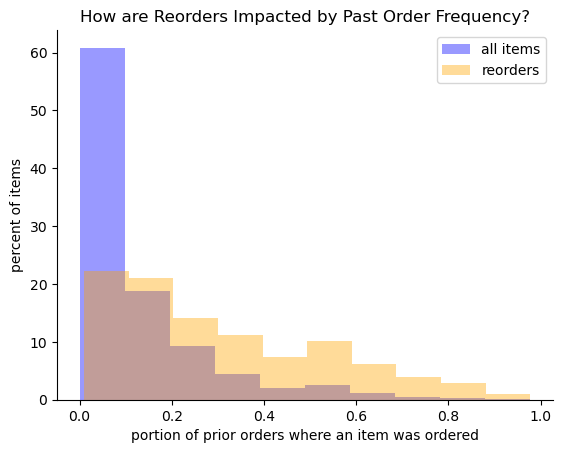

In [35]:
# Separate out reorders and non-reorders, then plot each as a histogram
# for purchased_percent_prior

reorders = df.loc[df['reordered']==1,:].copy()

sns.histplot(data=df, x='purchased_percent_prior', color='blue', alpha=0.4, bins=10, 
             stat='percent', linewidth=0).set(
    title='How are Reorders Impacted by Past Order Frequency?', 
    xlabel='portion of prior orders where an item was ordered', ylabel='percent of items')
sns.histplot(data=reorders, x='purchased_percent_prior', color='orange', alpha=0.4, bins=10, 
             stat='percent', linewidth=0)
sns.despine()
plt.legend(labels=['all items', 'reorders']);

Repeat this with the percent_past_purchased_early column, but first remove all non-orders. Otherwise the next chart will look extremely similar to that above by default, becaue of course if an item was added to the cart early, it was also purchased in the past. I'd rather see the distributions of items that are at least ordered, and how the past early-add behavior impacts reorders. 

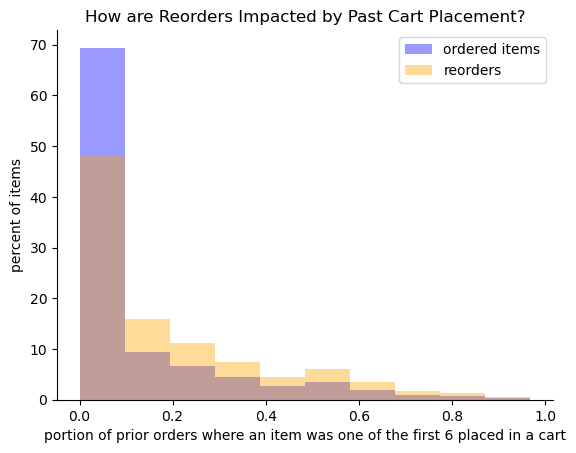

In [36]:
all_orders = df.loc[df['add_to_cart_sequence']>0,:].copy()
# The reorders dataframe above already indicates only items that are orders, of course. 

sns.histplot(data=all_orders, x='percent_past_purchased_early', color='blue', alpha=0.4, bins=10, 
             stat='percent', linewidth=0).set(
    title='How are Reorders Impacted by Past Cart Placement?', 
    xlabel='portion of prior orders where an item was one of the first 6 placed in a cart', 
    ylabel='percent of items')
sns.histplot(data=reorders, x='percent_past_purchased_early', color='orange', alpha=0.4, bins=10, 
             stat='percent', linewidth=0)
sns.despine()
plt.legend(labels=['ordered items', 'reorders']);

Even with non-orders removed, the plot still looks quite similar. The taller brown bar over 0.0 on the bottom plot shows that many items will get reordered even if they've not been placed in the cart early in the past. But, relative to all items that get ordered, reorders are indeed more likely to happen with those that have been ordered early in the past. 

Next, get a more specific picture of how reorders are distributed depending upon whether or not an item was ordered much in the past/ often added to the cart early. 

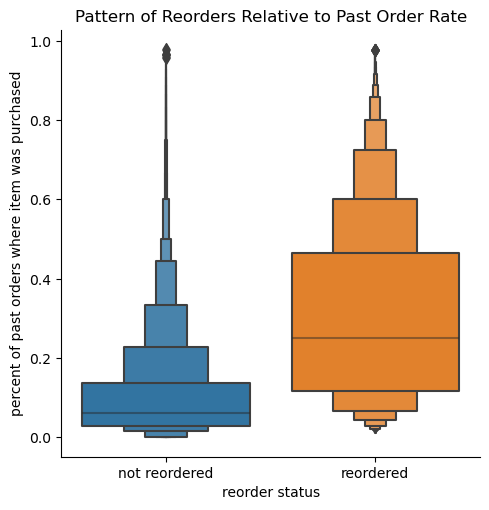

In [37]:
ax = sns.catplot(data=df, x="reordered", y="purchased_percent_prior", kind="boxen").set(
    title='Pattern of Reorders Relative to Past Order Rate', 
    xlabel='reorder status', ylabel='percent of past orders where item was purchased')
ax.set_xticklabels(['not reordered', 'reordered']);

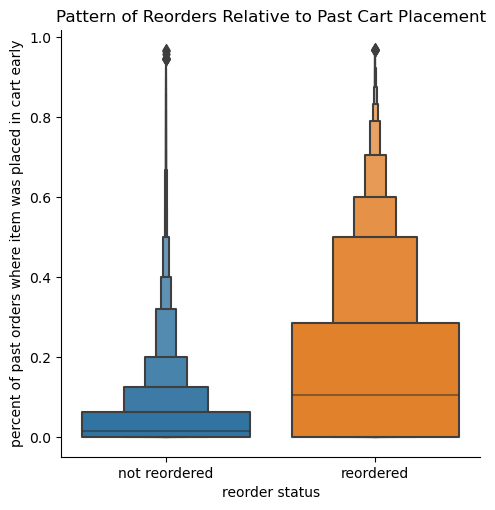

In [38]:
ax = sns.catplot(data=df, x="reordered", y="percent_past_purchased_early", 
                 kind="boxen").set(
    title='Pattern of Reorders Relative to Past Cart Placement', 
    xlabel='reorder status', ylabel='percent of past orders where item was placed in cart early')
ax.set_xticklabels(['not reordered', 'reordered']);

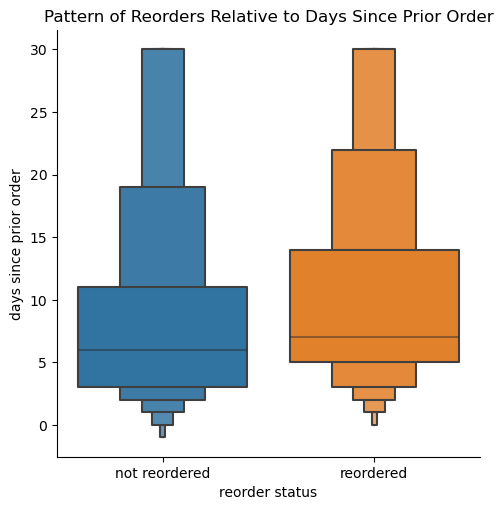

In [39]:
# Visualize the boxplot with one of the other, less-correlated categories
ax = sns.catplot(data=df, x="reordered", y="days_since_prior_order", 
                 kind="boxen").set(
    title='Pattern of Reorders Relative to Days Since Prior Order', 
    xlabel='reorder status', ylabel='days since prior order')
ax.set_xticklabels(['not reordered', 'reordered']);

**<font color='violet'>Conclusions and Next Steps</font>**

Relative to all items, reorders of products are much more likely to occur when they've been ordered in at least 10% of previous orders. Similarly, if an item was one of the first 6 to be placed in a cart in at least 10% of prior orders, it's more likely to be a reorder. Likewise, boxplots show that most items that don't get reordered are more likely to have little history of being ordered or placed in a cart early. No other numeric variables on their own are nearly as correlated with whether an item gets reordered or not. 

I can't do the rest of the encoding or normalization until I have a train/test split and pipeline for it. Save work done so far as new csv file and pick up in next notebook preprocessing3: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing3_encoding.ipynb

In [40]:
features_engineered = df
datapath = '../data/processed'
save_file(features_engineered, 'features_engineered.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/processed/features_engineered.csv"
